<a href="https://colab.research.google.com/github/bernhardtandy/ProjectsMLAI/blob/main/HW4_AndyBernhardt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projects in Machine Learning and AI Homework 4**
## *RNN/LSTM/GRU for Daily Average Temperature Prediction in Europe and Word Embeddings*
##### **Andy Bernhardt**
##### **bernha@rpi.edu**

---
## **Task 1: RNN/LSTM/GRU for Daily Average Temperature Prediction in Europe**

In this project, we will use a time-series dataset containing daily average temperatures in Europe, and apply a variety of sequential models to solve the task of predicting the next day's average temperature given the previous 30 days' average temperatures. Sequential models are appropriate for solving this problem because the data is a time-series; each data point has an intrinsic relationship to the previous data points and future data points (daily temperatures are not independent). As a result, sequential architectures such as RNNs, LSTMs, and GRUs can better capture these relationships (compared to other architectures) since the connections are built into the architecture; new inputs are combined with hidden states at each step to build new hidden states and eventually a final prediction. We use Tensorflow keras to implement the training and testing of all models.


---
### **Part 0: Dataset, Exploratory Data Analysis and Preprocessing**

In this section, we will do the following:
- Load the required libraries for the project and use GPU
- Load and describe the dataset
- Perform exploratory data analysis on the dataset
- Split the dataset into train, validation, and testing sets and preprocess


### Setup

In [44]:
# Import required libraries for project
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.utils import shuffle

import tensorflow as tf
from keras.utils.vis_utils import plot_model
from sklearn.metrics import mean_squared_error

In [2]:
# Check for GPU: Make sure the the runtime has a GPU hardware accelerator selected
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Load dataset from Google Drive

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Add HW4 folder to path
import sys
sys.path.append('/content/drive/MyDrive/ProjectsMLAI/HW4')

In [5]:
# Load daily average temperatures dataset
df = pd.read_csv("/content/drive/MyDrive/ProjectsMLAI/HW4/city_temperature.csv")
pd.set_option('display.max_columns', None)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Dataset description
  
The Daily Temperature of Major Cities dataset (from Kaggle) includes a CSV file containing daily average temperature measurements from a large number of cities in many countries and regions between 1995 and 2020. Each row contains the region, country, state, city, month, day, year, and average temperature, and the total number of measurements is 2,906,327. 

In this project, we consider the temperature measurements from cities in Europe, and consider only years where the average temperature data is complete.
Then, we break the dataset into 31 day sequences, where the goal is to predict the average temperature of the 31st day given the previous 30 average temperatures. We define, train, and then evaluate RNN, LSTM, GRU, and Feed Forward Networks for this task.

Link to dataset: https://www.kaggle.com/datasets/sudalairajkumar/daily-temperature-of-major-cities

### Initial preprocessing

In [7]:
# Show dataframe
df
# The dataframe has 2,906,327 rows

,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9
...,...,...,...,...,...,...,...,...
2906322,North America,US,Additional Territories,San Juan Puerto Rico,7,27,2013,82.4
2906323,North America,US,Additional Territories,San Juan Puerto Rico,7,28,2013,81.6
2906324,North America,US,Additional Territories,San Juan Puerto Rico,7,29,2013,84.2
2906325,North America,US,Additional Territories,San Juan Puerto Rico,7,30,2013,83.8


In [8]:
# Show distribution of data across regions
df.Region.value_counts()
# Most of the data points are from cities in North America
# We focus on cities in Europe for this project

North America                        1556681
Europe                                381990
Asia                                  316663
Africa                                251118
South/Central America & Carribean     219530
Middle East                           124749
Australia/South Pacific                55596
Name: Region, dtype: int64

In [9]:
# Extract data from European cities in the year range 1995 - 2022
df_europe = df[(df.Region == "Europe") & (df.Year >= 1995) & (df.Year <= 2022)]
df_europe.shape
# There are 381,695 relevant temperature observations from European cities

(381695, 8)

### Exploratory Data Analysis

In [10]:
# Show dataframe
df_europe

,Region,Country,State,City,Month,Day,Year,AvgTemperature
623377,Europe,Albania,NaN,Tirana,1,1,1995,-99.0
623378,Europe,Albania,NaN,Tirana,1,2,1995,-99.0
623379,Europe,Albania,NaN,Tirana,1,3,1995,-99.0
623380,Europe,Albania,NaN,Tirana,1,4,1995,-99.0
623381,Europe,Albania,NaN,Tirana,1,5,1995,-99.0
...,...,...,...,...,...,...,...,...
1005362,Europe,Yugoslavia,NaN,Belgrade,5,9,2020,66.2
1005363,Europe,Yugoslavia,NaN,Belgrade,5,10,2020,70.7
1005364,Europe,Yugoslavia,NaN,Belgrade,5,11,2020,72.5
1005365,Europe,Yugoslavia,NaN,Belgrade,5,12,2020,61.5


In [11]:
# Show column info
df_europe.info()
# The 'State' column contains only null values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 381695 entries, 623377 to 1005366
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Region          381695 non-null  object 
 1   Country         381695 non-null  object 
 2   State           0 non-null       object 
 3   City            381695 non-null  object 
 4   Month           381695 non-null  int64  
 5   Day             381695 non-null  int64  
 6   Year            381695 non-null  int64  
 7   AvgTemperature  381695 non-null  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 26.2+ MB


In [14]:
# Show counts of countries
df_europe.Country.value_counts()
# The data is spread across Europe, but with some countries having far more observations than others

Spain                27798
Switzerland          27798
Germany              24518
Italy                18532
United Kingdom       18532
France               18532
Russia               12492
Norway                9613
Slovakia              9266
Austria               9266
Romania               9266
Sweden                9266
Ukraine               9266
Portugal              9266
Poland                9266
The Netherlands       9266
Latvia                9266
Albania               9266
Ireland               9266
Iceland               9266
Hungary               9266
Finland               9266
Denmark               9266
Czech Republic        9266
Bulgaria              9266
Belgium               9266
Yugoslavia            9266
Macedonia             9265
Croatia               9265
Belarus               9264
Greece                6575
Cyprus                5652
Georgia               4378
Serbia-Montenegro     3427
Name: Country, dtype: int64

In [15]:
# Show counts of cities
df_europe.City.value_counts()
# The number of data points per city is similar, except for some cities that have less

Munich        9940
Oslo          9613
Tirana        9266
Barcelona     9266
Amsterdam     9266
Warsaw        9266
Lisbon        9266
Bucharest     9266
Moscow        9266
Bratislava    9266
Bilbao        9266
Vienna        9266
Madrid        9266
Stockholm     9266
Bern          9266
Geneva        9266
Zurich        9266
Kiev          9266
Belfast       9266
London        9266
Riga          9266
Rome          9266
Milan         9266
Dublin        9266
Brussels      9266
Sofia         9266
Prague        9266
Copenhagen    9266
Helsinki      9266
Paris         9266
Bordeaux      9266
Belgrade      9266
Budapest      9266
Reykjavik     9266
Zagreb        9265
Skopje        9265
Minsk         9264
Hamburg       7309
Athens        6575
Nicosia       5652
Tbilisi       4378
Frankfurt     4136
Pristina      3427
Yerevan       3226
Bonn          3133
Name: City, dtype: int64

In [16]:
# Show counts of years
df_europe.Year.value_counts()
# The dataset spans from 1995 to 2020, with generally more observations in earlier years

1996    16470
2000    16470
1997    16425
1998    16425
1999    16425
2001    16425
2002    16425
1995    16424
2003    16210
2004    15512
2005    15330
2006    15079
2008    14988
2011    14935
2010    14774
2007    14630
2009    14602
2012    13908
2018    13843
2019    13842
2016    13542
2015    13541
2013    13505
2014    13505
2017    13505
2020     4955
Name: Year, dtype: int64

In [17]:
# Show counts of months
df_europe.Month.value_counts()
# There are similar numbers of observations for each month

3     33201
1     33200
5     32489
4     32128
7     31960
8     31930
10    31930
12    31861
6     30951
9     30901
11    30870
2     30274
Name: Month, dtype: int64

In [18]:
# Show counts of days
df_europe.Day.value_counts()
# There are similar numbers of observations for each day (less for day 31 since not all months have 31 days)

3     12565
2     12565
11    12564
1     12563
8     12563
10    12563
9     12563
7     12563
6     12563
5     12563
4     12563
12    12561
13    12560
14    12526
18    12525
22    12525
19    12525
16    12525
17    12525
15    12525
20    12524
21    12524
23    12524
28    12524
24    12523
25    12523
26    12523
27    12522
29    11738
30    11487
31     7288
Name: Day, dtype: int64

In [13]:
# Show statistics of the average temperature variable
df_europe['AvgTemperature'].describe()
# We note that some values are -99.0, which is an invalid temperature

count    381695.000000
mean         46.808889
std          31.175564
min         -99.000000
25%          39.700000
50%          51.900000
75%          62.700000
max         102.500000
Name: AvgTemperature, dtype: float64

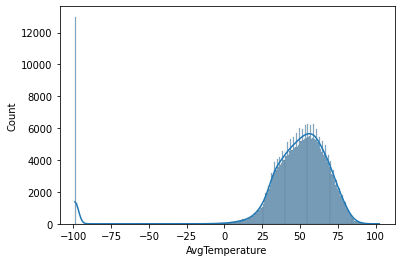

In [20]:
# We check if any other temperatures are invalid
sns.histplot(df_europe['AvgTemperature'], kde=True)
# It seems as though only -99.0 represents an invalid/missing observation,
# since all other values seem reasonable. We see that there are > 12,000 
# missing temperatures, and will have to account for this later

# The overall distribution of temperatures in Europe seems approximately normal

In [33]:
# Consider two cities: Barcelona and Stockholm
df_Barcelona = df_europe[df_europe.City == 'Barcelona']
df_Stockholm = df_europe[df_europe.City == 'Stockholm']
df_Barcelona.Year.value_counts(), df_Stockholm.Year.value_counts()
# These two cities have the same number of observations for each year

(2008    366
 2000    366
 2016    366
 2015    366
 2004    366
 2012    366
 1996    366
 2010    365
 2019    365
 2018    365
 2017    365
 2014    365
 2013    365
 2011    365
 1995    365
 2009    365
 2007    365
 2006    365
 2005    365
 2003    365
 2002    365
 2001    365
 1999    365
 1998    365
 1997    365
 2020    134
 Name: Year, dtype: int64, 2008    366
 2000    366
 2016    366
 2015    366
 2004    366
 2012    366
 1996    366
 2010    365
 2019    365
 2018    365
 2017    365
 2014    365
 2013    365
 2011    365
 1995    365
 2009    365
 2007    365
 2006    365
 2005    365
 2003    365
 2002    365
 2001    365
 1999    365
 1998    365
 1997    365
 2020    134
 Name: Year, dtype: int64)

count    9266.000000
mean       61.269264
std        14.025853
min       -99.000000
25%        53.000000
50%        60.900000
75%        71.000000
max        86.600000
Name: AvgTemperature, dtype: float64

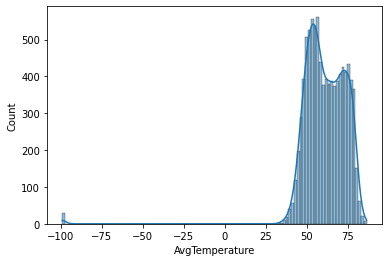

In [34]:
# Plot average temperatures from Barcelona
sns.histplot(df_Barcelona['AvgTemperature'], kde=True)
df_Barcelona['AvgTemperature'].describe()

count    9266.000000
mean       45.093503
std        16.840218
min       -99.000000
25%        34.500000
50%        44.800000
75%        57.900000
max        79.200000
Name: AvgTemperature, dtype: float64

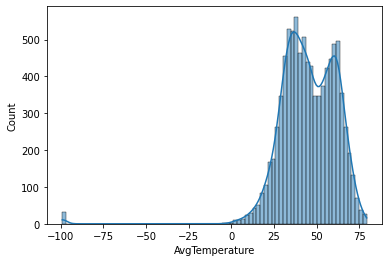

In [35]:
# Plot average temperatures from Stockholm
sns.histplot(df_Stockholm['AvgTemperature'], kde=True)
df_Stockholm['AvgTemperature'].describe()

In [37]:
# We see that these two cities have similar temperature distribution shapes,
# but Stockholm is generally cooler than Barcelona. This matches expectations based on geography.

### Data preprocessing and feature engineering

In [36]:
# Find city and year combinations where the year has 365 or 366 (leap year) temperature observations 
# and where the temperature observations are valid (not -99.0)
invalid_cities = []
invalid_years = []
valid_cities = []
valid_years = []
for city in df_europe.City.unique():
  df_city = df_europe[df_europe.City == city]
  for year in df_city.Year.unique():
    df_city_year = df_city[df_city.Year == year]
    if (df_city_year.shape[0] not in [365, 366] or -99.0 in df_city_year.AvgTemperature.unique()):
      invalid_cities.append(city)
      invalid_years.append(year)
    else:
      valid_cities.append(city)
      valid_years.append(year)

In [38]:
# We find that there are 580 invalid city/year combinations and 485 valid city and year combinations
len(invalid_cities), len(invalid_years), len(valid_cities), len(valid_years)

(580, 580, 485, 485)

In [39]:
# Extract only rows corresponding to valid city and year combinations
df_europe = df_europe[~df_europe[['Year', 'City']].apply(tuple, axis=1).isin(zip(invalid_years, invalid_cities))]
df_europe.shape
# We now have 177,168 relevant temperature observations from European cities

(177168, 8)

In [40]:
# Get all 31 day sequences of temperatures from each city/year combination
# Features are the first 30 day average temperatures
# Targets are the average temperature of the 31st day 
X = []
y = []
t = 30
for city in df_europe.City.unique():
  df_city = df_europe[df_europe.City == city]
  for year in df_city.Year.unique():
    df_city_year = df_city[df_city.Year == year]
    avg_temperature = list(df_city_year.AvgTemperature.values)
    for i in range(t, len(avg_temperature)):
      X.append(avg_temperature[i - t: i])
      y.append(avg_temperature[i])
X = np.asarray(X).astype("float")
y = np.asarray(y).reshape(-1, 1).astype("float")

In [41]:
# We have 162,618 total data points
X.shape, y.shape, X[0], y[0]
# We show an example data point below:

((162618, 30),
 (162618, 1),
 array([56.9, 51.3, 43.3, 37.9, 49. , 59.6, 55.7, 58.8, 57.1, 45.5, 44.9,
        45.6, 43.6, 42.6, 43.6, 44.8, 43.1, 43.3, 37.7, 38.3, 40.3, 37.2,
        36.2, 34. , 35.4, 38.6, 41.8, 43.5, 43.5, 49.3]),
 array([48.6]))

### Split data into training, validation, and testing sets and scale

In [42]:
# Split dataframe into training (70%), validation (20%), and testing (10%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=2./9., random_state=42)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape
# Show the sizes of the training, validation, and testing sets

((113832, 30), (113832, 1), (32524, 30), (32524, 1), (16262, 30), (16262, 1))

In [43]:
# Scale all features into the range [0, 1] based on the training data
sc_X = MinMaxScaler(feature_range=(0,1))
sc_Y = MinMaxScaler(feature_range=(0,1))
sc_X.fit(X_train)
sc_Y.fit(y_train)
sc_X.transform(X_train)
sc_Y.transform(y_train)
sc_X.transform(X_val)
sc_Y.transform(y_val)
sc_X.transform(X_test)
sc_Y.transform(y_test)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((113832, 30), (113832, 1), (32524, 30), (32524, 1), (16262, 30), (16262, 1))

### Final exploration

In [53]:
# Compute Pearson Correlation between each feature in the training data and the target
for i in range(30):
  X_i = X_train[:, i]
  print(f"Pearson Correlation between day {i + 1} temperature and day 31 temperature: {stats.pearsonr(X_i, y_train)[0][0]:.6f}")
# Here, we see that each of the average temperatures of the first 30 days has a strong relationship with the temperature of the 31st day
# As we get closer to the 31st day, the relationship is stronger, as expected
# As a result, given average temperature measurements for 30 days, we should be able to 
# very accurately predict the temperature of the next day in the dataset.

Pearson Correlation between day 1 temperature and day 31 temperature: 0.730184
Pearson Correlation between day 2 temperature and day 31 temperature: 0.737527
Pearson Correlation between day 3 temperature and day 31 temperature: 0.744371
Pearson Correlation between day 4 temperature and day 31 temperature: 0.751373
Pearson Correlation between day 5 temperature and day 31 temperature: 0.758165
Pearson Correlation between day 6 temperature and day 31 temperature: 0.764853
Pearson Correlation between day 7 temperature and day 31 temperature: 0.771679
Pearson Correlation between day 8 temperature and day 31 temperature: 0.777965
Pearson Correlation between day 9 temperature and day 31 temperature: 0.783738
Pearson Correlation between day 10 temperature and day 31 temperature: 0.788935
Pearson Correlation between day 11 temperature and day 31 temperature: 0.793187
Pearson Correlation between day 12 temperature and day 31 temperature: 0.797512
Pearson Correlation between day 13 temperature an

---
### **Part 1: RNN Implementation**

In this section, we define functions for creating models based on RNN, LSTM, GRU, and two-layer Feed Forward Network architectures, and also functions for training, evaluating, plotting the loss history, and plotting example predictions. We train an RNN model on the training set and describe the structure of this RNN, and finally evaluate the performance of this RNN on the validation and testing sets with respect to a regression metric.

In [ ]:
# This function creates an RNN model
# The input shape is 30 time-steps with 1 feature each
# The RNN layer has 100 hidden nodes with a tanh activation
# The output is produced by a dense layer with one neuron and a linear activation
def createRNN(name):

    input = tf.keras.layers.Input(shape=(30, 1), name='input', dtype='float64')
    X = tf.keras.layers.SimpleRNN(100, name='RNN_Layer', input_shape=(30, 1))(input)
    output = tf.keras.layers.Dense(1, name='FeedForward_Layer', activation='linear')(X)
    model = tf.keras.Model(name=name, inputs=input, outputs=output)

    return model

In [ ]:
# This function creates an LSTM model
# The input shape is 30 time-steps with 1 feature each
# The LSTM layer has 100 hidden nodes with a tanh activation
# The output is produced by a dense layer with one neuron and a linear activation
def createLSTM(name):

    input = tf.keras.layers.Input(shape=(30, 1), name='input', dtype='float64')
    X = tf.keras.layers.LSTM(100, name='LSTM_Layer', input_shape=(30, 1))(input)
    output = tf.keras.layers.Dense(1, name='FeedForward_Layer', activation='linear')(X)
    model = tf.keras.Model(name=name, inputs=input, outputs=output)

    return model

In [ ]:
# This function creates an GRU model
# The input shape is 30 time-steps with 1 feature each
# The GRU layer has 100 hidden nodes with a tanh activation
# The output is produced by a dense layer with one neuron and a linear activation
def createGRU(name):

    input = tf.keras.layers.Input(shape=(30, 1), name='input', dtype='float64')
    X = tf.keras.layers.GRU(100, name='GRU_Layer', input_shape=(30, 1))(input)
    output = tf.keras.layers.Dense(1, name='FeedForward_Layer', activation='linear')(X)
    model = tf.keras.Model(name=name, inputs=input, outputs=output)

    return model

In [ ]:
# This function creates an LSTM model
# The input shape is 30 features (the 30 time-steps)
# The two hidden layers use a ReLU activation and have 100 and 50 nodes, respectively
# The output is produced by a linear dense layer with one neuron
def createTwoLayerNN(name):
    input = tf.keras.layers.Input(shape=(30), name='input', dtype='float64')

    X = tf.keras.layers.Dense(100, name='hidden_layer_1', activation='relu')(input)
    X = tf.keras.layers.Dense(50, name='hidden_layer_2', activation='relu')(X)
    output = tf.keras.layers.Dense(1, name='output', activation='linear')(X)

    model = tf.keras.Model(name=name, inputs=input, outputs=output)

    return model

In [ ]:
# This function creates a model with the specified model_architecture
# and trains the model on the training data (X_train, y_train) given the 
# validation data (X_val, y_val) with a batch size batch_size.
# The model and training history structure are returned
# For all training, we apply early stopping on the validation loss with patience 10 to alleviate overfitting
# We use the Adam optimizer and mean squared error loss for regression
def train(model_architecture, name, X_train, y_train, X_val, y_val, batch_size):
  if (model_architecture == "RNN"):
    model = createRNN(name)
  elif (model_architecture == "LSTM"):
    model = createLSTM(name)
  elif (model_architecture == "GRU"):
    model = createGRU(name)
  elif (model_architecture == "NN"):
    model = createTwoLayerNN(name)
  es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=2, restore_best_weights=True)
  model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam())
  history = model.fit(x=X_train, y=y_train, steps_per_epoch=100, epochs=1000, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[es], verbose=2)
  return model, history

For this task, we use the root mean squared error metric for regression as our evaluation metric. If our predictions are closer to the targets, this number will be lower, indicating higher performance. 

$\text{RMSE} = \sqrt{\frac{\sum_{i=1}^{N}(y_i - \hat{y_i})^2}{N}}$, where $N$ is the number of observations, $y_i$ are the true targets, and $\hat{y_i}$ are the predictions.

In [ ]:
# This function evaluates a model based on the data (X, y)
# We use the root mean squared error metric for this problem since it is a regression model 
def evaluate(model, X, y):
    predictions = model.predict(X)
    rmse = mean_squared_error(y, predictions, squared=False)
    return rmse

In [ ]:
# This function produces a plot from the model training history structure,
# showing training and validation loss vs. epoch number
def plotHistory(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.xlabel("Epoch Number")
  plt.ylabel("Mean Squared Error Loss")
  plt.title("Mean Squared Error Loss vs. Epoch Number")
  plt.legend(["Training Loss", "Validation Loss"])
  plt.grid()
  plt.show()

In [ ]:
# This function obtains the true data from a city/year combination,
# splits the data into 31 day sequences, uses the model to predict values,
# and plots the true vs. predicted temperatures for each target day
def plotExample(model, city, year):
  df_example = df_europe[(df_europe.City == city) & (df_europe.Year == year)]
  
  avg_temperature = list(df_example.AvgTemperature.values)
  X_example = []
  y_example = []
  for i in range(t, len(avg_temperature)):
    X_example.append(avg_temperature[i - t: i])
    y_example.append(avg_temperature[i])
  X_example = np.asarray(X_example).astype("float")
  y_example = np.asarray(y_example).reshape(-1, 1).astype("float")

  predictions = model.predict(X_example)
  indices = range(1, len(predictions) + 1)

  plt.plot(indices, y_example, "g-")
  plt.plot(indices, predictions, "b-")
  plt.xlabel(f"Day of {year}")
  plt.ylabel(f"Temperature in {city}")
  plt.title(f"True vs. Predicted Temperatures For Each Day of {year} in {city}")
  plt.legend(["True Temperature", "Predicted Temperature"])
  plt.grid()
  plt.show()

In [ ]:
# This function takes multiple city/year combinations and uses plotExample() to plot
# example predictions for each city/year combination
def plotExamples(model, cities, years):
  for city, year in zip(cities, years):
    plotExample(model, city, year)

In [ ]:
# Train an RNN model on the training and validation data, with batch size 64
RNN, history = train("RNN", "RNN", X_train, y_train, X_val, y_val, 64)

Epoch 1/1000
100/100 - 4s - loss: 2104.9954 - val_loss: 1547.6057 - 4s/epoch - 44ms/step
Epoch 2/1000
100/100 - 4s - loss: 1255.1837 - val_loss: 994.8342 - 4s/epoch - 35ms/step
Epoch 3/1000
100/100 - 3s - loss: 802.9630 - val_loss: 641.1943 - 3s/epoch - 34ms/step
Epoch 4/1000
100/100 - 3s - loss: 521.6213 - val_loss: 415.6476 - 3s/epoch - 35ms/step
Epoch 5/1000
100/100 - 4s - loss: 343.5458 - val_loss: 274.8647 - 4s/epoch - 35ms/step
Epoch 6/1000
100/100 - 4s - loss: 219.4269 - val_loss: 188.5861 - 4s/epoch - 36ms/step
Epoch 7/1000
100/100 - 4s - loss: 162.3995 - val_loss: 132.4552 - 4s/epoch - 36ms/step
Epoch 8/1000
100/100 - 4s - loss: 113.8577 - val_loss: 96.9166 - 4s/epoch - 43ms/step
Epoch 9/1000
100/100 - 3s - loss: 86.1883 - val_loss: 73.0937 - 3s/epoch - 35ms/step
Epoch 10/1000
100/100 - 3s - loss: 66.2343 - val_loss: 57.4336 - 3s/epoch - 35ms/step
Epoch 11/1000
100/100 - 4s - loss: 52.1185 - val_loss: 46.5210 - 4s/epoch - 42ms/step
Epoch 12/1000
100/100 - 3s - loss: 43.9874 - 

In [ ]:
# Summarize the RNN model
RNN.summary()
# There are 10,301 total parameters in this model

Model: "RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 30, 1)]           0         
                                                                 
 RNN_Layer (SimpleRNN)       (None, 100)               10200     
                                                                 
 FeedForward_Layer (Dense)   (None, 1)                 101       
                                                                 
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


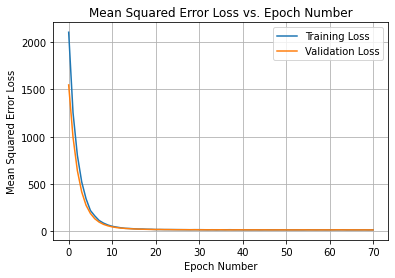

In [ ]:
# Plot the training and validation loss over the training loop
plotHistory(history)
# The loss starts high and soon becomes close to 0

In [ ]:
# Show the RNN model's final performance on the training data
rmse = evaluate(RNN, X_train, y_train)
print(f"Root Mean Squared Error: {rmse}")

3558/3558 [==============================] - 18s 5ms/step
(113832, 1)
Root Mean Squared Error: 3.7827752158022947


In [ ]:
# Evaluate the RNN model on the validation data
rmse = evaluate(RNN, X_val, y_val)
print(f"Root Mean Squared Error: {rmse}")

1017/1017 [==============================] - 5s 5ms/step
(32524, 1)
Root Mean Squared Error: 3.74709702876247


In [ ]:
# Evaluate the RNN model on the testing data
rmse = evaluate(RNN, X_test, y_test)
print(f"Root Mean Squared Error: {rmse}")

509/509 [==============================] - 2s 4ms/step
(16262, 1)
Root Mean Squared Error: 3.7881033753288063


11/11 [==============================] - 0s 9ms/step


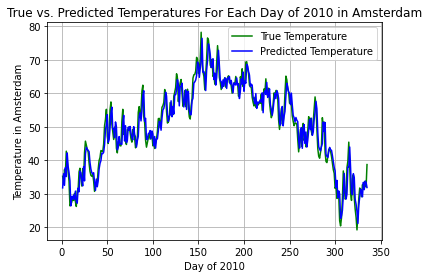

11/11 [==============================] - 0s 8ms/step


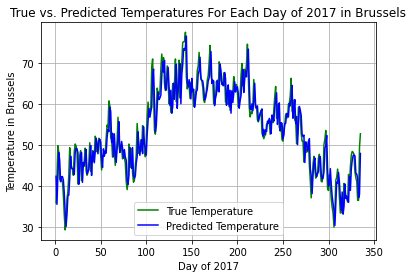

In [ ]:
# Show the true and predicted temperatures for Amsterdam in 2010 and Brussels in 2017
plotExamples(RNN, ["Amsterdam", "Brussels"], [2010, 2017])
# The RNN does a decent job at temperature prediction (note that some this data is spread between training, validation, and testing sets)

Ultimately, we see that the RNN model with 10,301 parameters achieves a 3.7471 RMSE on the validation set and a 3.7881 RMSE on the testing set. Based on plots of true vs. predicted temperatures, we see that the RNN has reasonable performance on this simple average temperature prediction task. 

---
### **Part 2: LSTM and GRU Implementation**

In this section, we use the functions defined in the previous section to train and evaluate LSTM and GRU models on the same dataset. We compare the results achieved by the RNN, LSTM, and GRU models. First, we train and evaluate a LSTM model.

In [ ]:
# Train an LSTM model on the training and validation data, with batch size 64
LSTM, history = train("LSTM", "LSTM", X_train, y_train, X_val, y_val, 64)

Epoch 1/1000
100/100 - 8s - loss: 2200.9543 - val_loss: 1567.2769 - 8s/epoch - 76ms/step
Epoch 2/1000
100/100 - 2s - loss: 1224.0676 - val_loss: 936.2256 - 2s/epoch - 21ms/step
Epoch 3/1000
100/100 - 3s - loss: 741.8434 - val_loss: 578.5663 - 3s/epoch - 25ms/step
Epoch 4/1000
100/100 - 3s - loss: 473.5758 - val_loss: 371.4652 - 3s/epoch - 33ms/step
Epoch 5/1000
100/100 - 2s - loss: 305.6320 - val_loss: 246.6284 - 2s/epoch - 23ms/step
Epoch 6/1000
100/100 - 3s - loss: 205.0999 - val_loss: 168.6482 - 3s/epoch - 30ms/step
Epoch 7/1000
100/100 - 3s - loss: 141.9341 - val_loss: 119.2830 - 3s/epoch - 32ms/step
Epoch 8/1000
100/100 - 3s - loss: 103.3094 - val_loss: 88.1963 - 3s/epoch - 32ms/step
Epoch 9/1000
100/100 - 2s - loss: 75.7704 - val_loss: 68.0700 - 2s/epoch - 17ms/step
Epoch 10/1000
100/100 - 2s - loss: 62.5575 - val_loss: 53.8241 - 2s/epoch - 17ms/step
Epoch 11/1000
100/100 - 2s - loss: 48.9939 - val_loss: 44.1599 - 2s/epoch - 17ms/step
Epoch 12/1000
100/100 - 2s - loss: 41.3971 - 

In [ ]:
# Summarize the LSTM model
LSTM.summary()
# There are 40,901 total parameters in this model

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 30, 1)]           0         
                                                                 
 LSTM_Layer (LSTM)           (None, 100)               40800     
                                                                 
 FeedForward_Layer (Dense)   (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


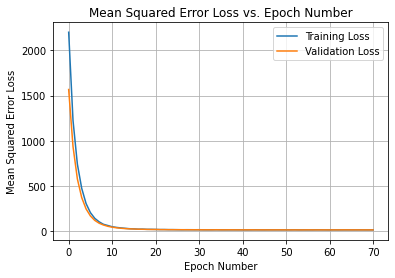

In [ ]:
# Plot the training and validation loss over the training loop
plotHistory(history)
# The loss starts high and soon becomes close to 0

In [ ]:
# Show the LSTM model's final performance on the training data
rmse = evaluate(LSTM, X_train, y_train)
print(f"Root Mean Squared Error: {rmse}")

3558/3558 [==============================] - 8s 2ms/step
Root Mean Squared Error: 3.7466454147702137


In [ ]:
# Evaluate the LSTM model on the validation data
rmse = evaluate(LSTM, X_val, y_val)
print(f"Root Mean Squared Error: {rmse}")

1017/1017 [==============================] - 2s 2ms/step
Root Mean Squared Error: 3.7158491728414917


In [ ]:
# Evaluate the LSTM model on the testing data
rmse = evaluate(LSTM, X_test, y_test)
print(f"Root Mean Squared Error: {rmse}")

509/509 [==============================] - 1s 2ms/step
Root Mean Squared Error: 3.7394364250986323


11/11 [==============================] - 0s 2ms/step


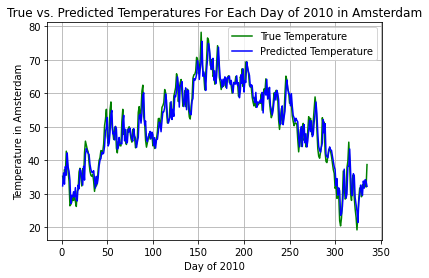

11/11 [==============================] - 0s 3ms/step


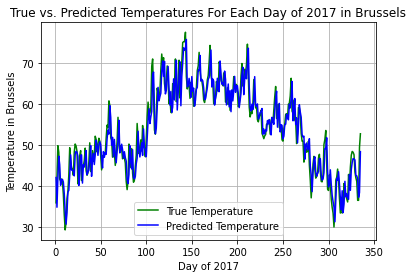

In [ ]:
# Show the true and predicted temperatures for Amsterdam in 2010 and Brussels in 2017
plotExamples(LSTM, ["Amsterdam", "Brussels"], [2010, 2017])
# The LSTM does a decent job at temperature prediction (note that some this data is spread between training, validation, and testing sets)

Next, we train and evaluate a GRU model.

In [ ]:
# Train a GRU model on the training and validation data, with batch size 64
GRU, history = train("GRU", "GRU", X_train, y_train, X_val, y_val, 64)

Epoch 1/1000
100/100 - 3s - loss: 2213.9500 - val_loss: 1525.5239 - 3s/epoch - 35ms/step
Epoch 2/1000
100/100 - 2s - loss: 1177.7036 - val_loss: 905.3490 - 2s/epoch - 20ms/step
Epoch 3/1000
100/100 - 2s - loss: 727.6160 - val_loss: 560.0621 - 2s/epoch - 20ms/step
Epoch 4/1000
100/100 - 2s - loss: 449.1410 - val_loss: 355.9564 - 2s/epoch - 15ms/step
Epoch 5/1000
100/100 - 2s - loss: 290.3579 - val_loss: 231.7807 - 2s/epoch - 17ms/step
Epoch 6/1000
100/100 - 1s - loss: 188.7583 - val_loss: 157.2505 - 1s/epoch - 14ms/step
Epoch 7/1000
100/100 - 2s - loss: 133.8284 - val_loss: 110.2528 - 2s/epoch - 16ms/step
Epoch 8/1000
100/100 - 2s - loss: 97.5199 - val_loss: 81.0323 - 2s/epoch - 15ms/step
Epoch 9/1000
100/100 - 1s - loss: 72.2521 - val_loss: 61.5535 - 1s/epoch - 15ms/step
Epoch 10/1000
100/100 - 1s - loss: 55.9548 - val_loss: 48.8985 - 1s/epoch - 15ms/step
Epoch 11/1000
100/100 - 2s - loss: 42.8927 - val_loss: 40.6978 - 2s/epoch - 17ms/step
Epoch 12/1000
100/100 - 2s - loss: 39.5399 - v

In [ ]:
# Summarize the GRU model
GRU.summary()
# There are 31,001 total parameters in this model

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 30, 1)]           0         
                                                                 
 GRU_Layer (GRU)             (None, 100)               30900     
                                                                 
 FeedForward_Layer (Dense)   (None, 1)                 101       
                                                                 
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________


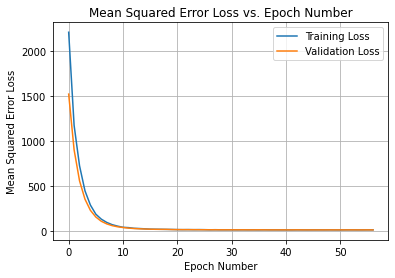

In [ ]:
# Plot the training and validation loss over the training loop
plotHistory(history)
# The loss starts high and soon becomes close to 0

In [ ]:
# Show the GRU model's final performance on the training data
rmse = evaluate(GRU, X_train, y_train)
print(f"Root Mean Squared Error: {rmse}")

3558/3558 [==============================] - 8s 2ms/step
Root Mean Squared Error: 3.772827886045608


In [ ]:
# Evaluate the GRU model on the validation data
rmse = evaluate(GRU, X_val, y_val)
print(f"Root Mean Squared Error: {rmse}")

1017/1017 [==============================] - 2s 2ms/step
Root Mean Squared Error: 3.7415732688882324


In [ ]:
# Evaluate the GRU model on the testing data
rmse = evaluate(GRU, X_test, y_test)
print(f"Root Mean Squared Error: {rmse}")

509/509 [==============================] - 1s 2ms/step
Root Mean Squared Error: 3.7575150314905046


11/11 [==============================] - 0s 2ms/step


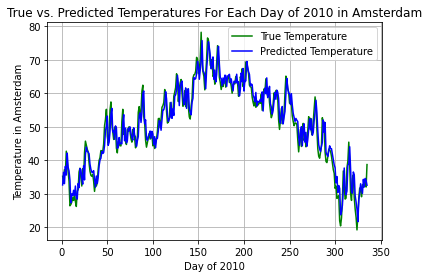

11/11 [==============================] - 0s 2ms/step


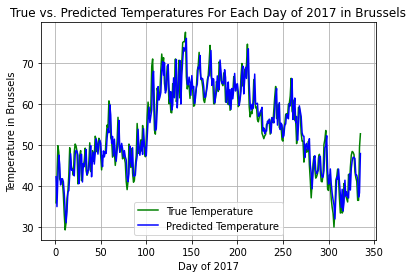

In [ ]:
# Show the true and predicted temperatures for Amsterdam in 2010 and Brussels in 2017
plotExamples(GRU, ["Amsterdam", "Brussels"], [2010, 2017])
# The GRU does a decent job at temperature prediction (note that some this data is spread between training, validation, and testing sets)

Ultimately, we compare the performance of the RNN, LSTM, and GRU models.
The root mean squared error for each model and dataset is shown below:

| Dataset | Training | Validation | Testing |
|:---:|:---:|:---:|:---:|
|**Model Architecture**| |||
|RNN| 3.7828|3.7471 |3.7881
|LSTM| **3.7466**| **3.7158**| **3.7394**
|GRU| 3.7728| 3.7416|3.7575

We see that given the same hyperparameters and layer sizes, the LSTM has the highest final performance on the training data, and achieves the best performance on the validation and testing sets, but by small margins. The GRU does better than the vanilla RNN, and its performance is consistently between the RNN and LSTM. Since the task is relatively simple, all three sequential models have high performance on the testing set. 

We note that although the number of hidden nodes in each model is the same, the number of parameters in the models is different. The RNN has 10,301 parameters, the LSTM has 40,901 parameters, and the GRU has 31,001 parameters. While the RNN has weights to combine new inputs with hidden states, the LSTM and GRU architectures extend this by adding cell states and/or gates. These gates have additional weights, which amplify the expressive power of the architecture (allowing the model to better remember and forget certain relationships in the input) and help these models achieve higher performance on the task. 



---
### **Part 3: Considering a Feed-Forward Network for Daily Average Temperature Prediction in Europe**

Next, we note that a traditional feed-forward network can also be used to solve the problem of predicting the next day's average temperature given the previous 30 days' average temperatures. The input features can be the previous 30 days' average temperatures, or can be engineered based on domain expertise. Since the task is relatively simple, and each of the features is highly correlated with the target, we note that a feed-forward network will also achieve decent performance on the task. The network may learn the relationships between the 30 days of data to produce a prediction, but the sequential nature of the data is not explicitly accounted for in the model's architecture. This is the main difference between using a sequential model for this task compared to a non-sequential model; the temporal relationships of the time-series data are already a part of the sequential models, whereas they must be learned in the case of a non-sequential model. To demonstrate that a feed-forward network can also solve this problem, we train and evaluate a feed-forward network on the dataset and compare the results to the results of the sequential models.


In [ ]:
# Train a two-layer Neural Network model on the training and validation data, with batch size 64
NN, history = train("NN", "NN", X_train, y_train, X_val, y_val, 64)

Epoch 1/1000
100/100 - 1s - loss: 125.9100 - val_loss: 28.1111 - 1s/epoch - 15ms/step
Epoch 2/1000
100/100 - 1s - loss: 24.8846 - val_loss: 24.5744 - 1s/epoch - 10ms/step
Epoch 3/1000
100/100 - 2s - loss: 21.9143 - val_loss: 18.7156 - 2s/epoch - 15ms/step
Epoch 4/1000
100/100 - 2s - loss: 18.2263 - val_loss: 17.3632 - 2s/epoch - 15ms/step
Epoch 5/1000
100/100 - 1s - loss: 17.9399 - val_loss: 17.5257 - 995ms/epoch - 10ms/step
Epoch 6/1000
100/100 - 1s - loss: 16.9678 - val_loss: 21.6255 - 988ms/epoch - 10ms/step
Epoch 7/1000
100/100 - 1s - loss: 18.8720 - val_loss: 15.8496 - 1s/epoch - 15ms/step
Epoch 8/1000
100/100 - 2s - loss: 16.1457 - val_loss: 15.2319 - 2s/epoch - 15ms/step
Epoch 9/1000
100/100 - 1s - loss: 15.9405 - val_loss: 16.0177 - 980ms/epoch - 10ms/step
Epoch 10/1000
100/100 - 1s - loss: 16.5054 - val_loss: 15.4480 - 1s/epoch - 15ms/step
Epoch 11/1000
100/100 - 1s - loss: 15.7221 - val_loss: 14.8066 - 992ms/epoch - 10ms/step
Epoch 12/1000
100/100 - 1s - loss: 16.1839 - val_l

In [ ]:
# Summarize the neural network model
NN.summary()
# There are 8,201 total parameters in this model

Model: "NN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 30)]              0         
                                                                 
 hidden_layer_1 (Dense)      (None, 100)               3100      
                                                                 
 hidden_layer_2 (Dense)      (None, 50)                5050      
                                                                 
 output (Dense)              (None, 1)                 51        
                                                                 
Total params: 8,201
Trainable params: 8,201
Non-trainable params: 0
_________________________________________________________________


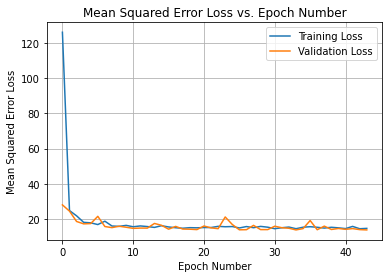

In [ ]:
# Plot the training and validation loss over the training loop
plotHistory(history)
# The loss starts high and soon becomes close to 0
# This loss fluctuates, as compared to the sequential model training loops

In [ ]:
# Show the NN model's final performance on the training data
rmse = evaluate(NN, X_train, y_train)
print(f"Root Mean Squared Error: {rmse}")

3558/3558 [==============================] - 5s 1ms/step
Root Mean Squared Error: 3.7604846159195704


In [ ]:
# Evaluate the NN model on the validation data
rmse = evaluate(NN, X_val, y_val)
print(f"Root Mean Squared Error: {rmse}")

1017/1017 [==============================] - 2s 1ms/step
Root Mean Squared Error: 3.7324955595833553


In [ ]:
# Evaluate the NN model on the testing data
rmse = evaluate(NN, X_test, y_test)
print(f"Root Mean Squared Error: {rmse}")

509/509 [==============================] - 1s 2ms/step
Root Mean Squared Error: 3.7680203409823054


11/11 [==============================] - 0s 2ms/step


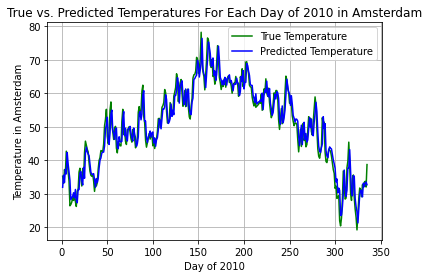

11/11 [==============================] - 0s 3ms/step


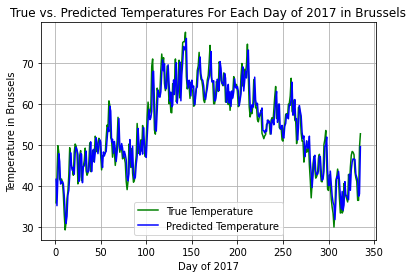

In [ ]:
# Show the true and predicted temperatures for Amsterdam in 2010 and Brussels in 2017
plotExamples(NN, ["Amsterdam", "Brussels"], [2010, 2017])
# The two-layer Neural Network does a decent job at temperature prediction (note that some this data is spread between training, validation, and testing sets)

Ultimately, we compare the performance of all four models.
The root mean squared error for each model and dataset is shown below:

| Dataset | Training | Validation | Testing |
|:---:|:---:|:---:|:---:|
|**Model Architecture**| |||
|RNN| 3.7828|3.7471 |3.7881
|LSTM| **3.7466**| **3.7158**| **3.7394**
|GRU| 3.7728| 3.7416|3.7575
|NN|3.7604|3.7325|3.7680

Here, we see that the two-layer neural network with 8,201 parameters' performance is comparable to the performance of the sequential models on the task of daily average temperature prediction in Europe. Given the simplicity of the task, the feed-forward network is expressive enough to capture the relationships between the 30 days of temperature data and the target day's temperature, and ultimately produce good predictions on the testing data.



---
## **Task 2: FastText Embeddings for Word Similarity and Dissimilarity**
 
In this section, we load pre-trained 300-dimensional FastText English word embeddings (https://fasttext.cc/docs/en/python-module.html), define functions for cosine similarity and dissimilarity of two words (using these embeddings), and show the similarity and dissimilarity scores for various pairs of words.

In [ ]:
# Install and load FastText library for Python 
!pip install fasttext
import fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 68 kB 4.7 MB/s 
  Using cached pybind11-2.10.0-py3-none-any.whl (213 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3169828 sha256=f95ff06885325a662f47aa12cc1e858d28a845d6227f132fad36ddbc2714db0f
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [ ]:
# Download the pre-trained 300-dimensional FastText English word embedding model and load the model 
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')
ft = fasttext.load_model('cc.en.300.bin')

In [ ]:
# This function calculates the cosine similarity of the FastText embeddings of word_1 and word_2
# The output ranges from -1 (vectors are in opposite directions)
# to 1 (indicating maximum similarity (vectors are in the same direction))
# An output of 0 indicates that words are not related (vectors are orthogonal)
def cosine_similarity(word_1, word_2):
  x = ft.get_word_vector(word_1)
  y = ft.get_word_vector(word_2)
  return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

As dissimilarity metrics, we note that we can use vector distance metrics such as Euclidean distance, Manhattan distance, Chebyshev distance etc.... However, Euclidean distance is not good in high dimensional spaces due to increased sparsity, and Manhattan distance can also suffer. We will use 1 - cosine similarity, as, intuitively, words that are similar should be less dissimilar, and words that are not similar should be more dissimilar. If dissimilarity is the opposite of similarity, and cosine similarity is a strong measure of similarity (by vector direction, independent of magnitude), then 1 - cosine similarity should be a good measure of dissimilarity. We note that since cosine similarity ranges from -1 to 1, this dissimilarity measure ranges from 0 to 2. However, since a similarity of 0 indicates unrelatedness, we can interpret a dissimilarity of 1 as unrelated. 

In [ ]:
# This function calculates the dissimilarity of the FastText embeddings of word_1 and word_2 using 1 - cosine similarity
# The output ranges from 0 (indicating no dissimilarity (vectors are in the same direction))
# to 2 (indicating maximum dissimilarity (vectors are in the opposite directions))
# An output of 1 indicates that the words are not related (vectors are orthogonal)
def dissimilarity(word_1, word_2):
  return 1 - cosine_similarity(word_1, word_2)

In [ ]:
# Consider two words "sadness" and "sorrow", which we may consider similar
word_1 = "sadness"
word_2 = "sorrow"
print(f"Cosine Similarity between {word_1} and {word_2}: {cosine_similarity(word_1, word_2)}")
print(f"Dissimilarity between {word_1} and {word_2}: {dissimilarity(word_1, word_2)}")

Cosine Similarity between sadness and sorrow: 0.8628993630409241
Dissimilarity between sadness and sorrow: 0.13710063695907593


In [ ]:
# Consider two words "anger" and "rage", which we may consider similar
word_1 = "anger"
word_2 = "rage"
print(f"Cosine Similarity between {word_1} and {word_2}: {cosine_similarity(word_1, word_2)}")
print(f"Dissimilarity between {word_1} and {word_2}: {dissimilarity(word_1, word_2)}")

Cosine Similarity between anger and rage: 0.7166127562522888
Dissimilarity between anger and rage: 0.2833872437477112


In [ ]:
# Consider two words "the" and "microphone", which we may consider dissimilar
word_1 = "the"
word_2 = "microphone"
print(f"Cosine Similarity between {word_1} and {word_2}: {cosine_similarity(word_1, word_2)}")
print(f"Dissimilarity between {word_1} and {word_2}: {dissimilarity(word_1, word_2)}")

Cosine Similarity between the and microphone: 0.15792231261730194
Dissimilarity between the and microphone: 0.8420776873826981


In [ ]:
# Consider two words "halcyon" and "paper", which we may consider dissimilar
word_1 = "halcyon"
word_2 = "paper"
print(f"Cosine Similarity between {word_1} and {word_2}: {cosine_similarity(word_1, word_2)}")
print(f"Dissimilarity between {word_1} and {word_2}: {dissimilarity(word_1, word_2)}")

Cosine Similarity between halcyon and paper: 0.026520151644945145
Dissimilarity between halcyon and paper: 0.9734798483550549
